In [1]:
dataset_path = './realwaste/realwaste-main/RealWaste'

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize (mean, std for RGB)
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split into training and validation datasets
train_size = int(0.6 * len(dataset))
test_size = int(0.2 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print class names
print("Classes:", dataset.classes)


Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, x1, m1, x2, m2, x3, d, K):
        super(CustomCNN, self).__init__()

        # First Convolutional Layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=x1, kernel_size=m1, stride=1, padding=m1 // 2)
        self.activation1 = nn.ReLU()  

        # MaxPooling Layer 1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=x1, out_channels=x2, kernel_size=m2, stride=1, padding=m2 // 2)
        self.activation2 = nn.ReLU()  

        # MaxPooling Layer 2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer
        self.fc1 = nn.Linear(x2 * (128 // 4) * (128 // 4), x3)  # Adjust dimensions based on input size and pooling
        self.activation3 = nn.ReLU()  
        self.dropout = nn.Dropout(d)  # Dropout layer

        # Output Layer
        self.fc2 = nn.Linear(x3, K)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)

        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer

        x = self.fc1(x)
        x = self.activation3(x)
        x = self.dropout(x)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Softmax activation

# Define the model parameters
x1, m1 = 32, 3  # Filters and kernel size for the first convolutional layer
x2, m2 = 64, 3  # Filters and kernel size for the second convolutional layer
x3 = 128        # Number of units in the fully connected layer
d = 0.5         # Dropout rate
K = len(dataset.classes)  # Number of output classes

# Instantiate the model
model = CustomCNN(x1, m1, x2, m2, x3, d, K)

# Print the model architecture
print(model)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (activation3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)


In [5]:
# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, check the PyTorch CUDA version
if cuda_available:
    print(f"CUDA version supported by PyTorch: {torch.version.cuda}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available in this PyTorch installation.")

CUDA available: True
CUDA version supported by PyTorch: 11.8
Number of GPUs available: 1
Current GPU: NVIDIA GeForce GTX 1650


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model, loss function, and optimizer
model = CustomCNN(x1, m1, x2, m2, x3, d, K)  # Define your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training parameters
num_epochs = 20  # Number of epochs
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)


        # Train Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Calculate Train Accuracy as percentage
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%",
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/20, Train Loss: 1.9574, Train Accuracy: 30.06% Validation Loss: 1.5337, Validation Accuracy: 45.85%
Epoch 2/20, Train Loss: 1.5672, Train Accuracy: 46.55% Validation Loss: 1.4059, Validation Accuracy: 51.63%
Epoch 3/20, Train Loss: 1.4251, Train Accuracy: 49.46% Validation Loss: 1.2989, Validation Accuracy: 55.31%
Epoch 4/20, Train Loss: 1.3069, Train Accuracy: 53.56% Validation Loss: 1.2036, Validation Accuracy: 57.10%
Epoch 5/20, Train Loss: 1.1664, Train Accuracy: 57.87% Validation Loss: 1.1664, Validation Accuracy: 58.46%
Epoch 6/20, Train Loss: 1.0608, Train Accuracy: 61.07% Validation Loss: 1.1538, Validation Accuracy: 60.25%
Epoch 7/20, Train Loss: 0.9750, Train Accuracy: 63.70% Validation Loss: 1.0205, Validation Accuracy: 64.77%
Epoch 8/20, Train Loss: 0.8536, Train Accuracy: 68.15% Validation Loss: 1.0113, Validation Accuracy: 64.04%
Epoch 9/20, Train Loss: 0.7210, Train Accuracy: 73.55% Validation Loss: 1.0703, Validation Accuracy: 62.78%
Epoch 10/20, Train Loss: 0.6

In [9]:
# Testing phase
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.4534, Test Accuracy: 65.79%


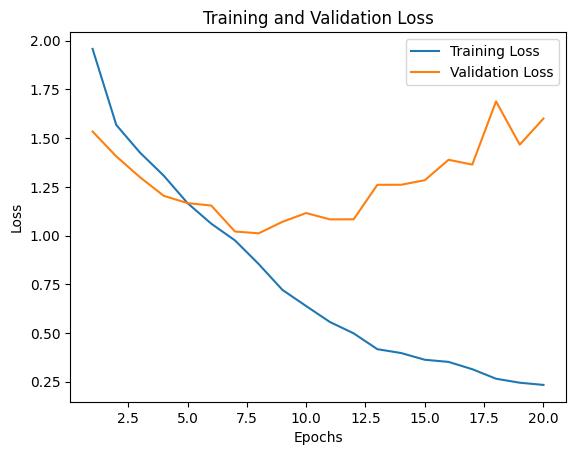

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model, loss function, and optimizer
model = CustomCNN(x1, m1, x2, m2, x3, d, K)  # Define your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training parameters
num_epochs = 8  # Number of epochs
train_losses = []
val_losses = []

# Training and validation loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Clear gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item() * images.size(0)


        # Train Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Calculate Train Accuracy as percentage
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {epoch_train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%",
          f"Validation Loss: {epoch_val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")



Epoch 1/8, Train Loss: 1.9723, Train Accuracy: 30.83% Validation Loss: 1.5407, Validation Accuracy: 46.79%
Epoch 2/8, Train Loss: 1.5053, Train Accuracy: 46.90% Validation Loss: 1.3172, Validation Accuracy: 52.79%
Epoch 3/8, Train Loss: 1.2821, Train Accuracy: 54.58% Validation Loss: 1.1702, Validation Accuracy: 58.46%
Epoch 4/8, Train Loss: 1.0986, Train Accuracy: 61.98% Validation Loss: 1.1216, Validation Accuracy: 59.94%
Epoch 5/8, Train Loss: 0.9484, Train Accuracy: 66.57% Validation Loss: 1.0935, Validation Accuracy: 61.09%
Epoch 6/8, Train Loss: 0.7830, Train Accuracy: 72.19% Validation Loss: 1.1126, Validation Accuracy: 61.20%
Epoch 7/8, Train Loss: 0.6864, Train Accuracy: 74.96% Validation Loss: 1.1058, Validation Accuracy: 62.57%
Epoch 8/8, Train Loss: 0.5965, Train Accuracy: 78.22% Validation Loss: 1.1005, Validation Accuracy: 62.25%


In [12]:
# Testing phase
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.0738, Test Accuracy: 63.58%


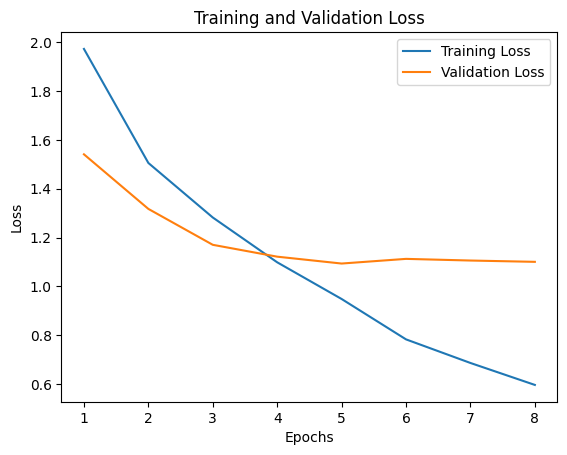

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
